# Logistic Regression

In [149]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Load data.

In [150]:
datafile1 = os.path.join('data', 'ex2data1.txt')
data1 = pd.read_csv(datafile1, names=['exam1_scores', 'exam2_scores', 'outcome'])

In [151]:
exam_scores = np.asarray(data1[["exam1_scores", "exam2_scores"]])
outcome = np.asarray(data1["outcome"])

Visualize the data.

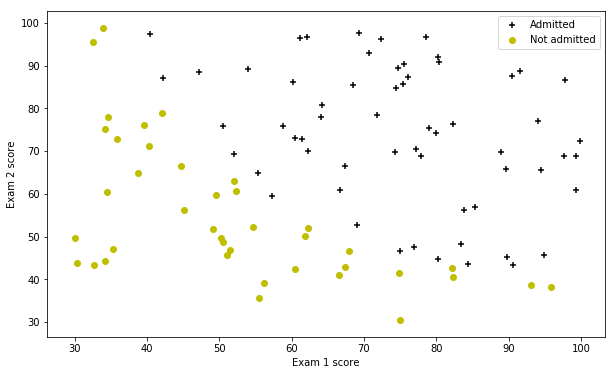

In [152]:
pos = exam_scores[outcome==1]
neg = exam_scores[outcome==0]
def plot_data():
    plt.figure(figsize=(10, 6))
    plt.scatter(pos[:, 0], pos[:, 1], c='k', marker='+', label='Admitted')
    plt.scatter(neg[:, 0], neg[:, 1], c='y', label='Not admitted')
    plt.legend(loc='upper right')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')

plot_data()

# Implementation of Cost Function

Sigmoid function. SciPy provides an optimized sigmoid function, so I will use that.

In [153]:
from scipy.special import expit

In [154]:
expit(np.arange(-5, 5))

array([0.00669285, 0.01798621, 0.04742587, 0.11920292, 0.26894142,
       0.5       , 0.73105858, 0.88079708, 0.95257413, 0.98201379])

Cost function and its gradient.

In [155]:
def cost_function(theta, x, y):
    m = len(y)
    hypothesis = expit(np.dot(x, theta))
    term1 = -y * np.log(hypothesis)
    term2 = -(1 - y) * np.log(1 - hypothesis)
    cost = np.sum(term1 + term2) / m
    return cost

In [156]:
def gradient(theta, x, y):
    # Note to self. None in the following is the same as np.newaxis.
    m = y.size
    hypothesis = expit(np.dot(x, theta))
    return np.sum((hypothesis - y)[:, None] * x, axis=0) / m

The last part is to minimize the cost function with respect to theta. I will use the truncated Newton's Method, `fmin_tnc`, from the `scipy.optimize` module for that.

In [157]:
from scipy.optimize import fmin_tnc

def optimize_theta(theta, x, y):
    result = fmin_tnc(cost_function, theta, gradient, (x, y))
    return result[0]

Training

In [158]:
exam_scores_with_intercept = np.insert(exam_scores, 0, 1, axis=1)
initial_theta = np.zeros(exam_scores_with_intercept.shape[1])

In [159]:
theta = optimize_theta(initial_theta, exam_scores_with_intercept, outcome)

In [160]:
theta

array([-25.16131863,   0.20623159,   0.20147149])

### Decision Boundary

The decision boundary is given by $h_\theta(x) = 0$, i.e. $\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0$. Here $x_1$ and $x_2$ correspond to the scores in exams 1 and 2 respectively. We can rearrange the equation to 
$$ x_2 = -\frac{1}{\theta_2}(\theta_1 x_1 + \theta_0).$$
This is the equation of a line. To graph a line we need only two points.

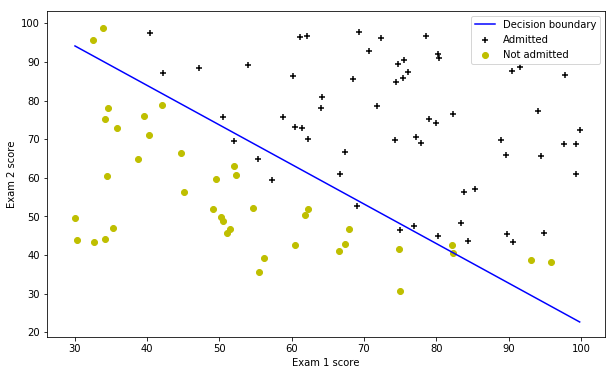

In [161]:
x1 = np.array([exam_scores[:,0].min(), exam_scores[:,0].max()])
x2 = -(theta[1] * x1 + theta[0]) / theta[2]
plot_data()
plt.plot(x1, x2, 'b-', label='Decision boundary')
plt.legend()

### Prediction
We can now use these values of the $\theta$ parameters to predict if a student will be admitted, based on their scores in the two exams. The hypothesis gives the probability of admission of the student. If it evaluates to 0.5 or higher then we will interpret it as a positive result, otherwise we will interpret it as a negative result.

In [162]:
def predict(theta, x):
    return expit(np.dot(x, theta)) >= 0.5

In [163]:
predict(theta, np.array([1, 45, 85]))

True

In [164]:
# Check the accuracy of the classifier on the training set.
predict_pos = np.sum(predict(theta, exam_scores_with_intercept[outcome==1]))
predict_neg = np.sum(np.logical_not(predict(theta, exam_scores_with_intercept[outcome==0])))
predict_total = predict_pos + predict_neg
accuracy = predict_total / (len(pos) + len(neg))
accuracy

0.89

Thus the classifier has a 89% accuracy on the training set.

# Regularized Logistic Regression

Load data.

In [165]:
datafile2 = os.path.join('data', 'ex2data2.txt')
data2 = pd.read_csv(datafile2, names=['Test 1 scores', 'Test 2 scores', 'outcome'])

In [166]:
test_scores = np.asarray(data2[["Test 1 scores", "Test 2 scores"]])
outcome = np.asarray(data2["outcome"])

Visualize data.

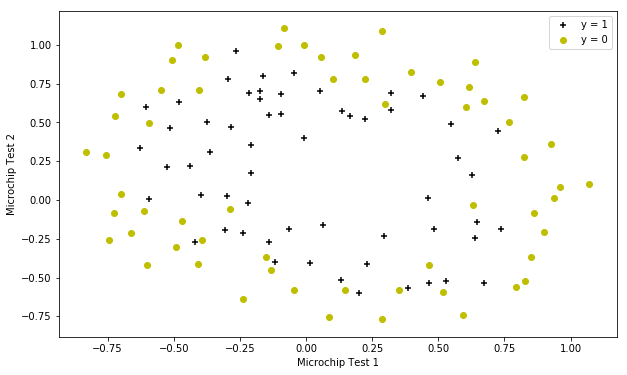

In [167]:
pos = test_scores[outcome==1]
neg = test_scores[outcome==0]
def plot_data():
    plt.figure(figsize=(10, 6))
    plt.scatter(pos[:, 0], pos[:, 1], c='k', marker='+', label='y = 1')
    plt.scatter(neg[:, 0], neg[:, 1], c='y', label='y = 0')
    plt.legend(loc='upper right')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')

plot_data()

It is clear from the above graph that the data cannot be separated into positive and negative results by a straight line. To fit the data better we will have to increase the number of features. One way of doing this is by considering higher powers of the given data.

In [168]:
def map_feature(x1, x2):
    m = len(x1)
    output = np.ones(m).reshape(m, 1)
    degree = 6
    
    for i in np.arange(1, degree+1):
        for j in np.arange(0, i+1):
            new_features = (x1**(i-j) * x2**j).reshape(m ,1)
            output = np.hstack((output, new_features))
    return output

In [169]:
mapped_scores = map_feature(test_scores[:, 0], test_scores[:, 1])

In [170]:
mapped_scores.shape

(118, 28)

### Regularized cost function

Since we have increased the number of features, we should also regularize the cost function and its gradient to avoid potential overfitting.

In [171]:
def reg_cost_function(theta, x, y, regulator):
    m = len(y)
    theta2 = regulator * np.sum(theta ** 2) / (2*m)
    return cost_function(theta, x, y) + theta2

In [172]:
def reg_gradient(theta, x, y, regulator):
    m = len(y)
    n = len(theta)
    reg_theta = np.ones(n-1) * regulator / m
    reg_theta = np.insert(reg_theta, 0, 0)
    reg_theta = reg_theta * theta
    return gradient(theta, x, y) + reg_theta

Checks

In [173]:
initial_theta = np.zeros(mapped_scores.shape[1])
regulator = 1
cost = reg_cost_function(initial_theta, mapped_scores, outcome, regulator)
grad = reg_gradient(initial_theta, mapped_scores, outcome, regulator)

In [174]:
cost, grad[:5]

(0.6931471805599454,
 array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
        1.15013308e-02]))

In [175]:
initial_theta = np.ones(mapped_scores.shape[1])
regulator = 10
cost = reg_cost_function(initial_theta, mapped_scores, outcome, regulator)
grad = reg_gradient(initial_theta, mapped_scores, outcome, regulator)

In [176]:
cost, grad[:5]

(3.2068822129709416,
 array([0.34604507, 0.16135192, 0.19479576, 0.22686278, 0.09218568]))

For minimization we will use the `minimize` routine from the `scipy.optimize` module. This is more generic than the `fmin_tnc` used earlier.

In [177]:
from scipy.optimize import minimize
def reg_optimize_theta(theta, x, y, regulator=0):
    result = minimize(reg_cost_function, theta,
                      args=(x, y, regulator), jac=reg_gradient,
                      method='TNC', options={"maxiter": 500})
    return result.x

In [178]:
initial_theta = np.zeros(mapped_scores.shape[1])
theta = reg_optimize_theta(initial_theta, mapped_scores, outcome)

In [179]:
theta

array([   16.38135326,    23.44731203,    21.95622753,  -168.99287019,
        -108.92001229,   -73.86197698,  -179.11123001,  -300.3381286 ,
        -204.90258101,   -70.95680672,   587.41031643,   705.88680307,
         848.94704171,   432.42674309,   135.65297187,   309.57701844,
         747.76890129,  1013.19434408,   857.21957181,   383.56300106,
          81.125412  ,  -675.53157564, -1230.92250666, -1920.28830983,
       -1835.79360739, -1510.84373037,  -624.60520925,  -119.93891189])

### Decision boundary

The decision boundary is produced by computing the classifiers prediction at each point on an evenly spaced grid, and then drawing a contour where the prediction changes from 0 to 1.

In [180]:
def plot_decision_boundary(theta):
    x1 = np.linspace(-1, 1.5, 50)
    x2 = np.linspace(-1, 1.5, 50)
    z = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            z[i][j] = np.dot(map_feature(np.array([x1[i]]), np.array([x2[j]])), theta)
    u, v = np.meshgrid(x1, x2)
    plt.contour(x1, x2, z, [0])

Text(0.5, 1.0, 'regulator = 0')

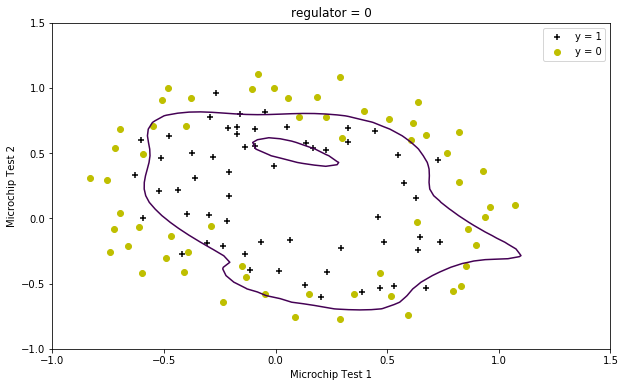

In [181]:
plot_data()
plot_decision_boundary(theta)
plt.title('regulator = 0')

Text(0.5, 1.0, 'regulator = 1')

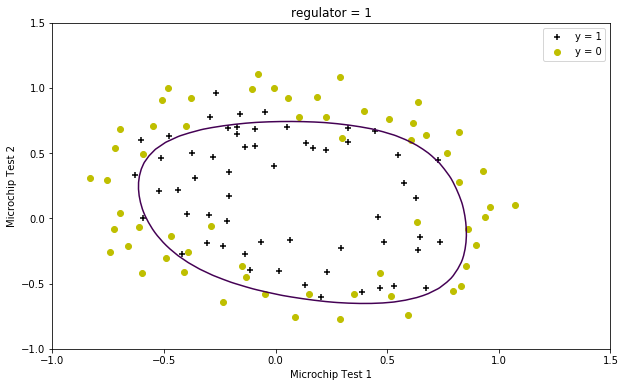

In [182]:
theta = reg_optimize_theta(initial_theta, mapped_scores, outcome, 1)
plot_data()
plot_decision_boundary(theta)
plt.title('regulator = 1')

Text(0.5, 1.0, 'regulator = 100')

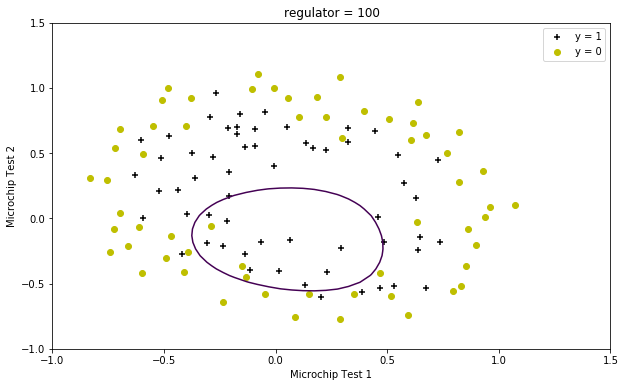

In [183]:
theta = reg_optimize_theta(initial_theta, mapped_scores, outcome, 100)
plot_data()
plot_decision_boundary(theta)
plt.title('regulator = 100')

From the graphs it appears that choosing the regulator to be zero, possibly overfits the data, while choosing the regulator to be hundred underfits the data. Choosing one for the regulator gives a reasonable classifier.

In [191]:
np.dot(mapped_scores.T, (expit(np.dot(mapped_scores, theta)) - outcome)).shape

(28,)

In [193]:
outcome.shape == np.dot(mapped_scores, theta).shape

True